In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import copy
from pathlib import Path
import seaborn as sns
import torchaudio
from math import sqrt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch.utils.data import Dataset
from torchvision import transforms
import torch 
from torch import nn 
from torch.utils.data import DataLoader
from timm.models.layers import trunc_normal_, DropPath #Necesario instalar !pip install timm
import torchaudio
from IPython.display import Audio, display
import torchaudio.transforms as T
import random
import librosa
from torch.nn.utils import weight_norm
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

#Semillas de reproducibilidad 
seed = 40
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


#Configurar el dispositivo 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def load_data(path):
    dir_dic = {}
    for root, dirs, files in os.walk(path):
        for dir in dirs:
            if '_background_noise_' in dir:
                continue
            dir_path = os.path.join(root, dir)
            file_list = [os.path.join(dir_path, file) for file in os.listdir(dir_path)]
            dir_dic[dir] = file_list
    return dir_dic

def files_to_csv(files_dic):
    # Crear un diccionario de etiquetas basado en los directorios
    labels_map = {label: idx for idx, label in enumerate(files_dic.keys())}
    
    # Crear listas para las rutas de archivos y sus etiquetas
    file_paths = []
    file_labels = []
    
    for label, files in files_dic.items():
        for file in files:
            file_paths.append(file)
            file_labels.append(labels_map[label])
    
    # Crear el DataFrame
    df = pd.DataFrame({'files': file_paths, 'labels': file_labels})
    df['files'] = df['files'].apply(lambda x: x.replace("\\", "/"))
    
    return df

def play_and_plot_audio(file_path):
    try:
        # Cargar la señal de audio
        waveform, sample_rate = torchaudio.load(file_path)
        
        # Reproducir el audio
        display(Audio(waveform.numpy(), rate=sample_rate))
        
        # Graficar la señal de audio
        plt.figure(figsize=(10, 4))
        plt.plot(waveform.t().numpy())  # Transponer para asegurar que sea (time, channel)
        plt.title(f'Señal de Audio: {file_path}')
        plt.xlabel('Tiempo')
        plt.ylabel('Amplitud')
        plt.show()
    except Exception as e:
        print(f"Error al cargar el archivo {file_path}: {e}")

In [3]:
path = 'archive'
files = load_data(path)
files_df = files_to_csv(files)

In [4]:
files_df.head(-1)

,files,labels
0,archive/bed/00176480_nohash_0.wav,0
1,archive/bed/004ae714_nohash_0.wav,0
2,archive/bed/004ae714_nohash_1.wav,0
3,archive/bed/00f0204f_nohash_0.wav,0
4,archive/bed/00f0204f_nohash_1.wav,0
...,...,...
64715,archive/zero/ffd2ba2f_nohash_0.wav,29
64716,archive/zero/ffd2ba2f_nohash_1.wav,29
64717,archive/zero/ffd2ba2f_nohash_2.wav,29
64718,archive/zero/ffd2ba2f_nohash_3.wav,29


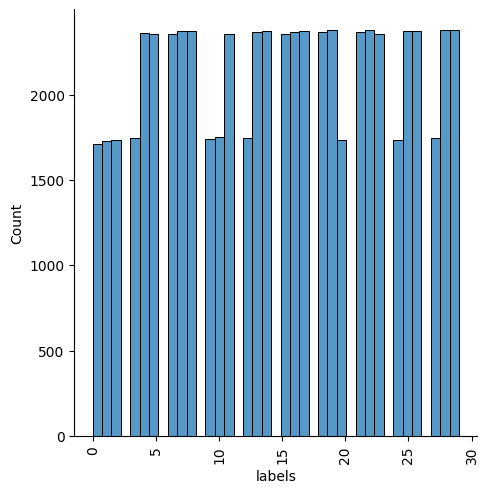

In [5]:
#Grafica de todos los datos 
sns.displot(files_df.labels)
plt.xticks(rotation=90)
plt.show()

### Realizamos la división del dataset con 75% entrenamiento 20% validación y 5% prueba

In [6]:
# Dividir en entrenamiento (75%) y restante (25%)
train_df, temp_df = train_test_split(
    files_df, 
    test_size=0.25, 
    stratify=files_df['labels'], 
    random_state=42
)

# Dividir el conjunto restante en validación (20%) y prueba (5%)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.2, 
    stratify=temp_df['labels'], 
    random_state=42
)

In [7]:
# Verificar las distribuciones
print(f"Entrenamiento: {len(train_df)} muestras")
print(f"Validación: {len(val_df)} muestras")
print(f"Prueba: {len(test_df)} muestras")

Entrenamiento: 48540 muestras
Validación: 12944 muestras
Prueba: 3237 muestras


### Histograma de las clases para entrenamiento

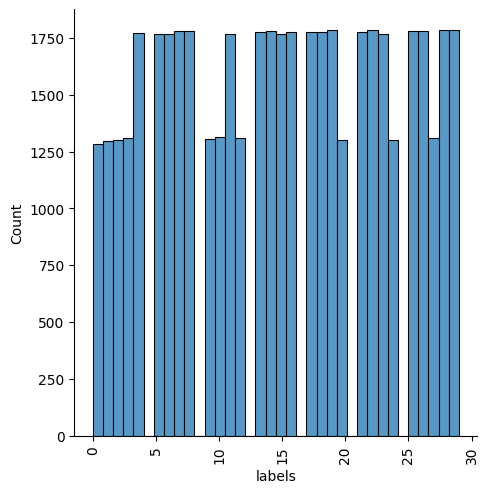

In [8]:
#Grafica de los datos de entrenamiento
sns.displot(train_df.labels)
plt.xticks(rotation=90)
plt.show()

### Histograma de clases para validación

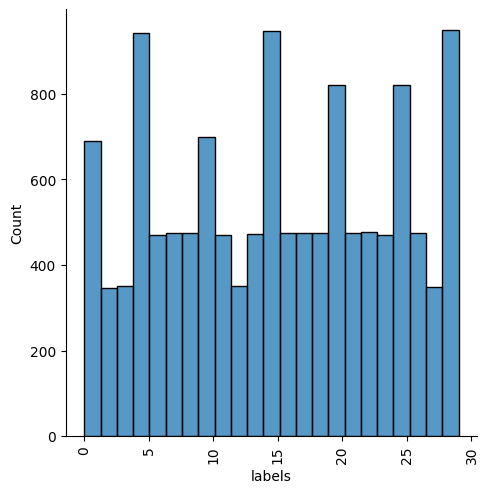

In [9]:
#Grafica de los datos de validacion
sns.displot(val_df.labels)
plt.xticks(rotation=90)
plt.show()

### Histograma clases para set de pruebas

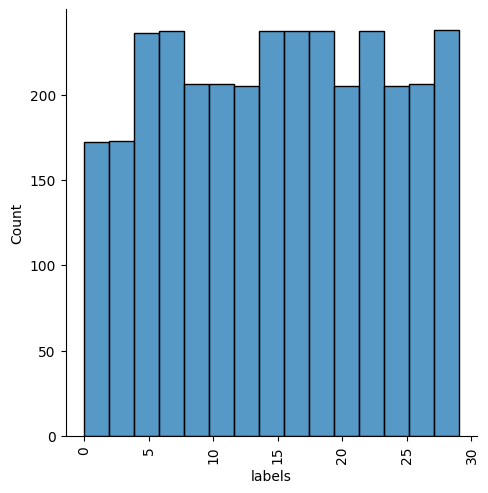

In [10]:
#Grafica de los datos de prueba
sns.displot(test_df.labels)
plt.xticks(rotation=90)
plt.show()

#### Se puede observar que en genrar las clases se encuentran balanceadas después de realizar las divisiones de entrenamiento, validación y pruebas

### REPRODUCIOMOS ALGUNAS MUESTRAS DE AUDIO DENTRO DE CADA SET

Ejemplo de entrenamiento:


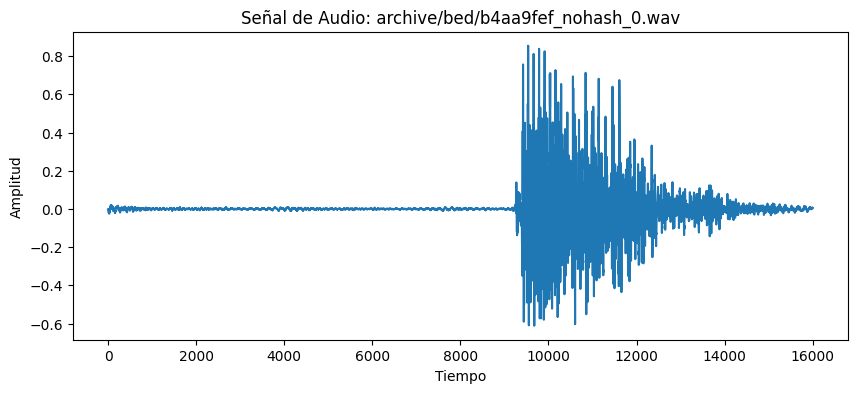

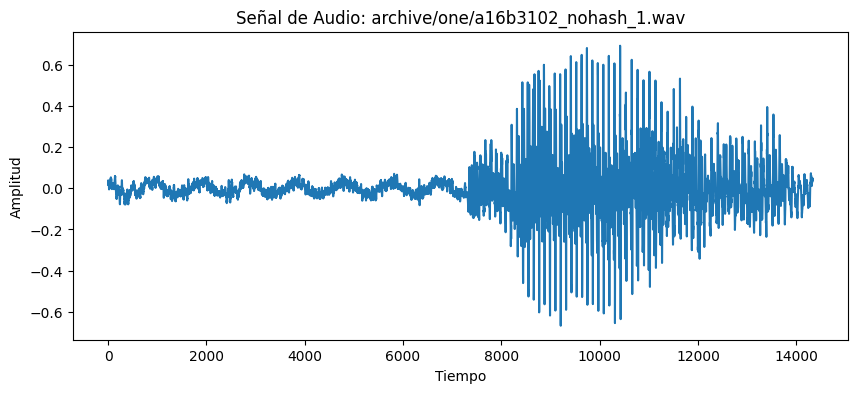

Ejemplo de validación:


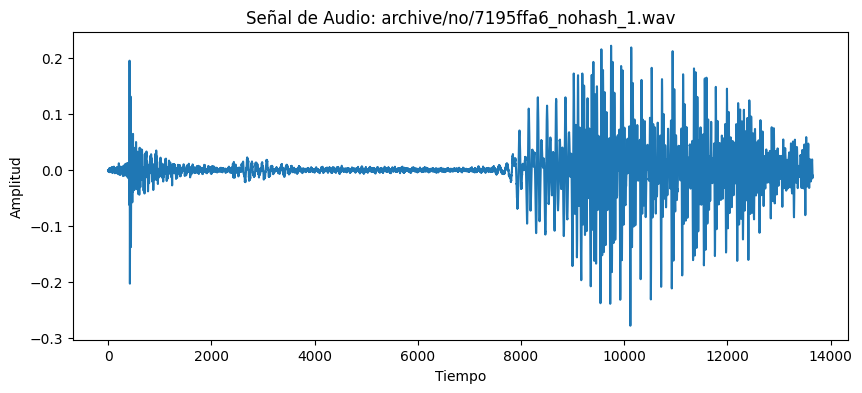

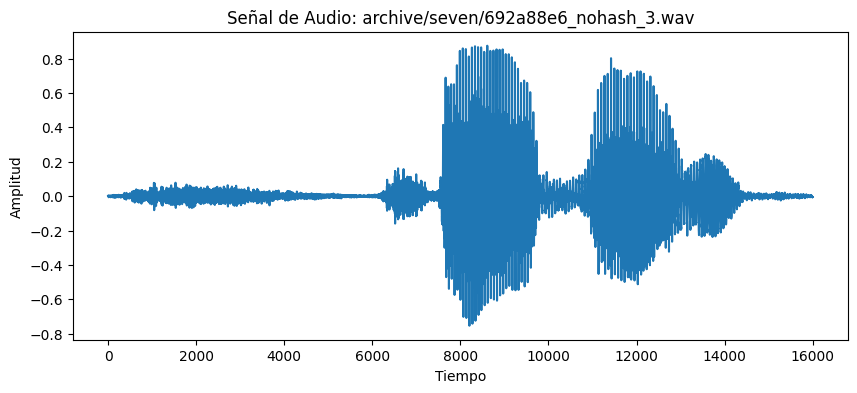

Ejemplo de prueba:


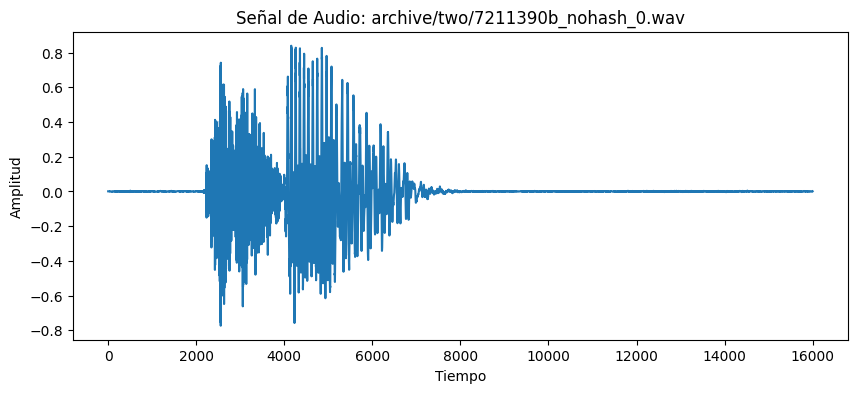

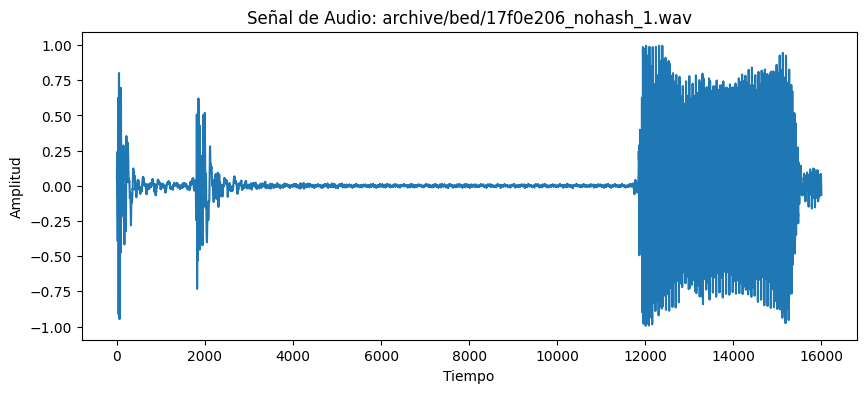

In [11]:
# Reproducir y graficar algunos archivos de cada conjunto
print("Ejemplo de entrenamiento:")
for i in range(2):
    play_and_plot_audio(train_df.iloc[i]['files'])

print("Ejemplo de validación:")
for i in range(2):
    play_and_plot_audio(val_df.iloc[i]['files'])

print("Ejemplo de prueba:")
for i in range(2):
    play_and_plot_audio(test_df.iloc[i]['files'])

### Creamos las clase, métodos y funciones necesarias para los cargadores de datos 

In [12]:
class SpeechCommands(Dataset):
    def __init__(self,files_df, transforms=None):
                        
        self.transform = transforms
        self.files_df = files_df

    
    def __len__(self):
        return len(self.files_df)
    
    def __getitem__(self, idx):
        
        file_name = self.files_df.iloc[idx,0]
        # Cargar el archivo de audio
        waveform, sample_rate = torchaudio.load(file_name)
         # Obtener la etiqueta de clase numérica
        label =self.files_df.iloc[idx, -1]
        
        # Aplicar transformaciones si están definidas
        if self.transform:
            waveform = self.transform(waveform)
        return waveform, label


#### Se crea el espectograma MEL con una frecuencia de muestreo de 16k, con 128 bandas MEL por espectograma

In [13]:
# Definir la transformación a Mel Spectrogram
mel_transform = T.MelSpectrogram(
    sample_rate=16000,        # frecuencia de muestreo de tus audios
    n_mels=128,               # Número de bandas Mel
    n_fft=2048,               # Tamaño de la ventana FFT
    hop_length=512,           # Paso entre las ventanas de FFT
    power=2.0                 # Magnitud del espectrograma (2 para la energía)
)

def librosa_resize(waveform, target_length=16000, sr=16000):
    current_length = waveform.size(1)
    
    # Calcular la tasa de cambio
    waveform_np = waveform.numpy().flatten()  # Convertir a numpy
    rate = target_length / current_length

    # Cambiar la longitud de la señal usando librosa.resample
    waveform_resized = librosa.resample(waveform_np, orig_sr=sr, target_sr=sr * rate)

    # Ajustar exactamente al tamaño deseado (16000)
    waveform_resized = librosa.util.fix_length(waveform_resized, size=target_length)
    
    return torch.tensor(waveform_resized).unsqueeze(0)

# Transformación para añadir ruido aleatorio
def add_noise(waveform, noise_factor=0.005):
    noise = torch.randn(waveform.size()) * noise_factor
    noisy_waveform = waveform + noise
    return noisy_waveform

# Transformación de aumento de datos
def augment_audio(waveform):
    # Aumentos de datos aleatorios
    transforms = [
        lambda x: add_noise(x, noise_factor=0.01),  # Añadir ruido aleatorio
        T.Vol(0.5 + random.random()),  # Cambia el volumen aleatoriamente
        T.TimeMasking(time_mask_param=500),  # Mascara de tiempo aleatoria
    ]
    for transform in transforms:
        if random.random() > 0.6:  # Aplicar con probabilidad del 50%
            waveform = transform(waveform)
    return waveform

In [14]:
train_transform_img = transforms.Compose([
    transforms.Lambda(librosa_resize),
    transforms.Lambda(augment_audio),
    mel_transform, 
    #transforms.Lambda(lambda x: x.unsqueeze(0)) 
])

In [15]:
val_transforms_img = transforms.Compose([
    transforms.Lambda(librosa_resize),
    mel_transform, 
    #transforms.Lambda(lambda x: x.unsqueeze(0)) 
])

In [16]:
# aplicar las transofrmaciones a los datos 
train_dataset_img = SpeechCommands( files_df=train_df, transforms=train_transform_img)
val_dataset_img = SpeechCommands( files_df=val_df, transforms=val_transforms_img)
test_dataset_img = SpeechCommands( files_df=test_df, transforms=val_transforms_img)

In [17]:
train_dataset_img.files_df.head()

,files,labels
1187,archive/bed/b4aa9fef_nohash_0.wav,0
37220,archive/one/a16b3102_nohash_1.wav,17
32393,archive/off/918a2473_nohash_4.wav,15
58193,archive/up/fac7deca_nohash_1.wav,26
29976,archive/no/918a2473_nohash_2.wav,14


In [18]:
# Verificar la carga de audio como espectograma MEL (chan, mel_bands, len)
print('Set de entrenamiento')
for i in range(0, 5):
    audio, label = train_dataset_img[i]
    print(f"Audio {i}: {audio.shape}, Etiqueta: {label}")
    
print('\nSet de validación')
for i in range(0, 5):
    audio, label = val_dataset_img[i]
    print(f"Audio {i}: {audio.shape}, Etiqueta: {label}")

print('\nSet de prueba')
for i in range(0, 5):
    audio, label = test_dataset_img[i]
    print(f"Audio {i}: {audio.shape}, Etiqueta: {label}")

Set de entrenamiento
Audio 0: torch.Size([1, 128, 32]), Etiqueta: 0
Audio 1: torch.Size([1, 128, 32]), Etiqueta: 17
Audio 2: torch.Size([1, 128, 32]), Etiqueta: 15
Audio 3: torch.Size([1, 128, 32]), Etiqueta: 26
Audio 4: torch.Size([1, 128, 32]), Etiqueta: 14

Set de validación
Audio 0: torch.Size([1, 128, 32]), Etiqueta: 14
Audio 1: torch.Size([1, 128, 32]), Etiqueta: 19
Audio 2: torch.Size([1, 128, 32]), Etiqueta: 0
Audio 3: torch.Size([1, 128, 32]), Etiqueta: 13
Audio 4: torch.Size([1, 128, 32]), Etiqueta: 29

Set de prueba
Audio 0: torch.Size([1, 128, 32]), Etiqueta: 25
Audio 1: torch.Size([1, 128, 32]), Etiqueta: 0
Audio 2: torch.Size([1, 128, 32]), Etiqueta: 15
Audio 3: torch.Size([1, 128, 32]), Etiqueta: 23
Audio 4: torch.Size([1, 128, 32]), Etiqueta: 19


In [22]:
# Función para verificar el tamaño de las muestras
def verificar_dimensiones(dataset, expected_size=torch.Size([1, 128, 32])):
    incorrect_count = 0
    for i in tqdm(range(len(dataset))):
        audio, label = dataset[i]
        if audio.size() != expected_size:
            incorrect_count += 1
            print(f"Muestra {i} tiene un tamaño incorrecto: {audio.size()}")  # Opcional: mostrar las muestras que no cumplen
    return incorrect_count

In [23]:
# Verificar las dimensiones de los datasets de entrenamiento, validación y prueba
incorrect_train = verificar_dimensiones(train_dataset_img)
incorrect_val = verificar_dimensiones(val_dataset_img)
incorrect_test = verificar_dimensiones(test_dataset_img)

# Mostrar los resultados
print(f"Muestras incorrectas en el set de entrenamiento: {incorrect_train}")
print(f"Muestras incorrectas en el set de validación: {incorrect_val}")
print(f"Muestras incorrectas en el set de prueba: {incorrect_test}")

100%|██████████| 3237/3237 [00:05<00:00, 611.09it/s]

Muestras incorrectas en el set de entrenamiento: 0
Muestras incorrectas en el set de validación: 0
Muestras incorrectas en el set de prueba: 0


In [19]:
train_dl = DataLoader(
    train_dataset_img,
    batch_size=96,
    shuffle=True
)

val_dl = DataLoader(
    val_dataset_img,
    batch_size=96,
    shuffle=True
)

In [20]:
it_entdl = iter(train_dl)
lote = next(it_entdl)
print(f'Prueba Audio Train (tamaño)= {lote[0].shape}, Categorías (tamaño)= {lote[1].shape}')

it_valdl = iter(val_dl)
lote_val = next(it_valdl)
print(f'Prueba Audio Test (tamaño)= {lote_val[0].shape}, Categorías (tamaño)= {lote_val[1].shape}')

Prueba Audio Train (tamaño)= torch.Size([96, 1, 128, 32]), Categorías (tamaño)= torch.Size([96])
Prueba Audio Test (tamaño)= torch.Size([96, 1, 128, 32]), Categorías (tamaño)= torch.Size([96])


In [21]:
# Función para graficar un espectrograma Mel
def plot_mel_spectrogram(mel_img, label, idx):
    # Eliminar la dimensión del canal si es necesario
    mel_img = mel_img.squeeze().cpu().numpy()  # Eliminar todas las dimensiones con tamaño 1

    plt.figure(figsize=(10, 4))
    plt.imshow(mel_img, aspect='auto', origin='lower')
    plt.title(f'Spectrograma Mel - Ejemplo {idx + 1} - Clase: {label}')
    plt.colorbar(format="%+2.0f dB")
    plt.xlabel('Tiempo')
    plt.ylabel('Frecuencia')
    plt.show()

# Graficar un lote de ejemplos del DataLoader
def plot_batch_mel_spectrograms(dataloader, num_samples=3):
    batch = next(iter(dataloader))
    mel_imgs, labels = batch

    for i in range(num_samples):
        plot_mel_spectrogram(mel_imgs[i], labels[i].item(), i)

### Graficamos algunas muestras de los espectogramas MEL generados para cada set

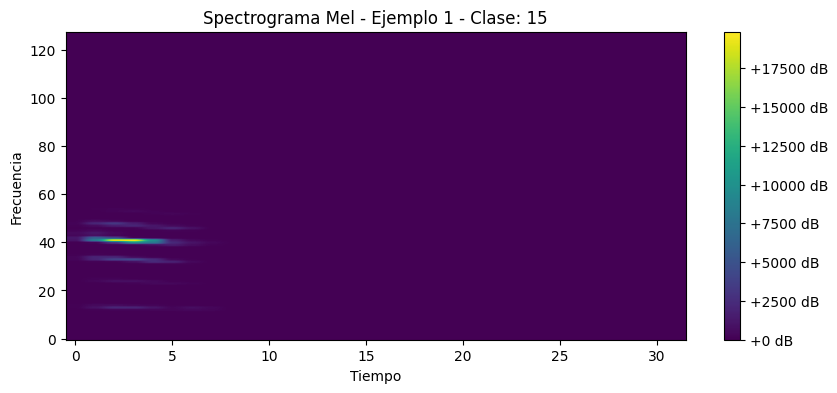

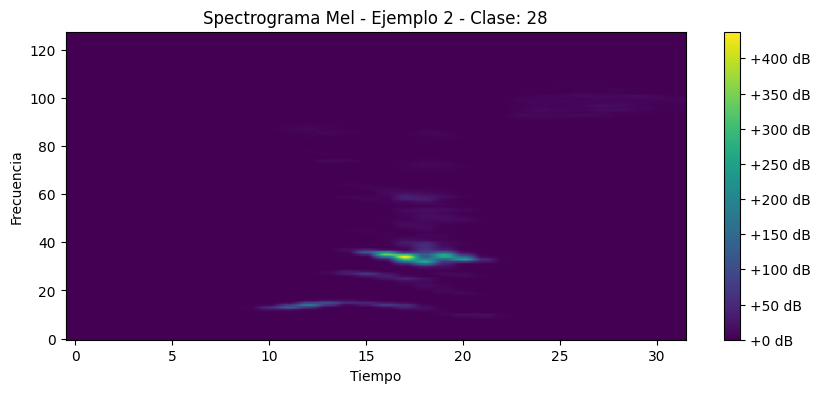

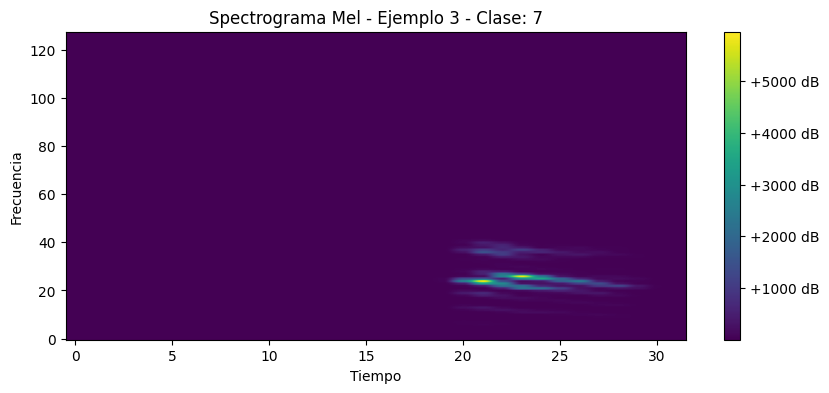

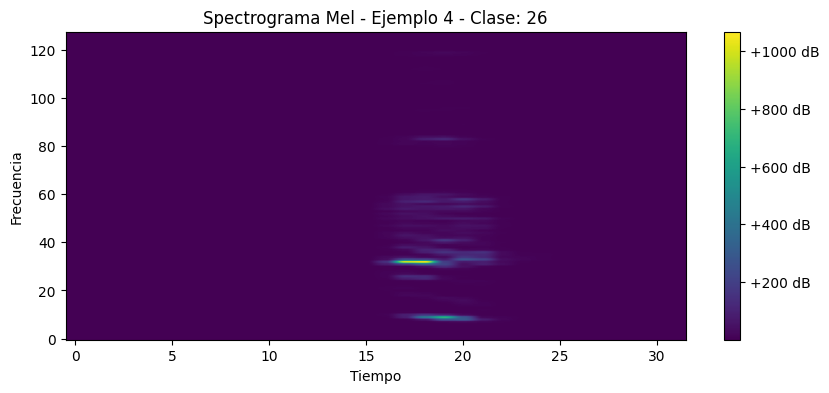

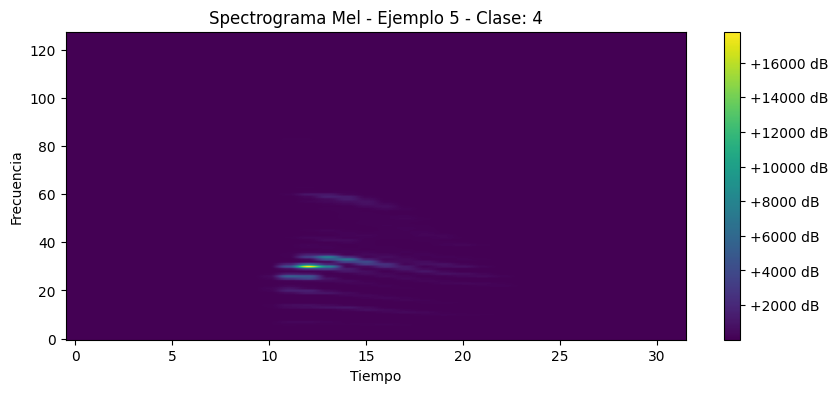

In [22]:
# Dataloader de entrenamiento
plot_batch_mel_spectrograms(train_dl, num_samples=5)

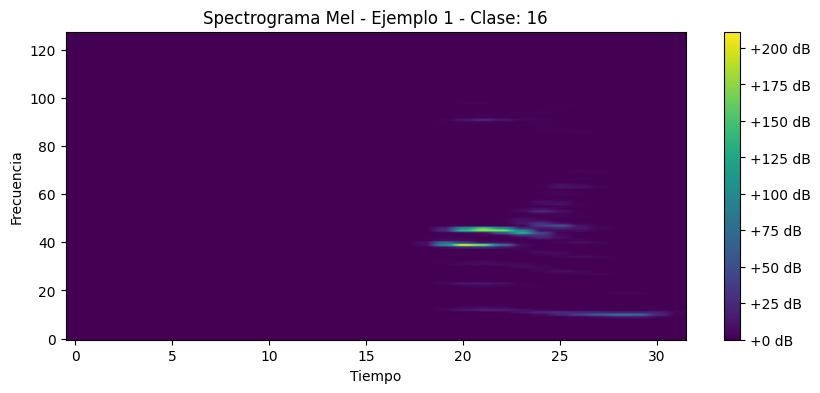

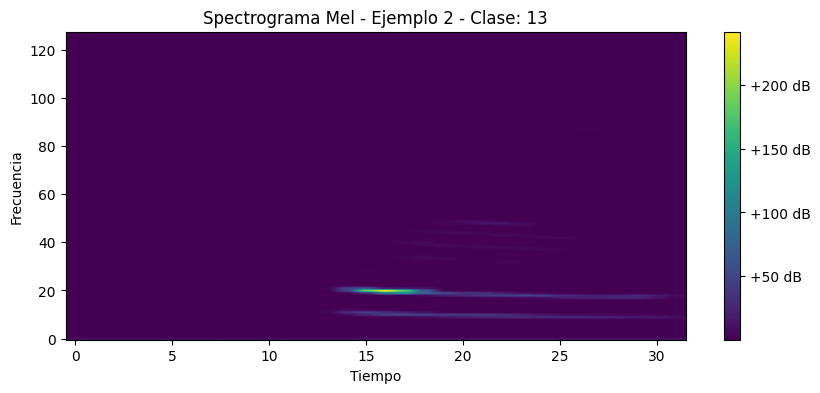

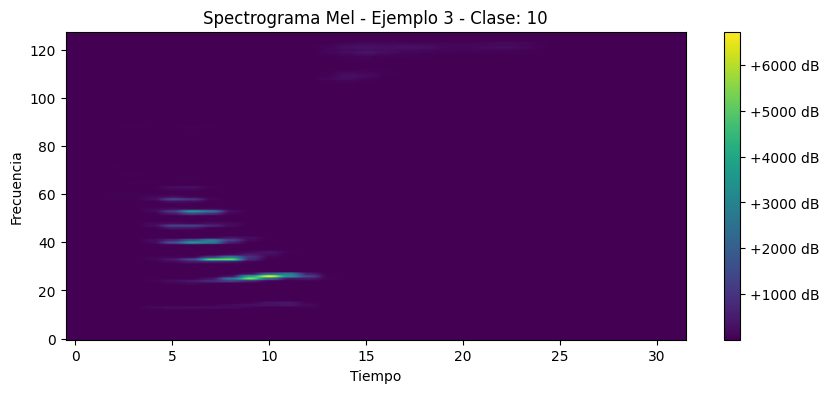

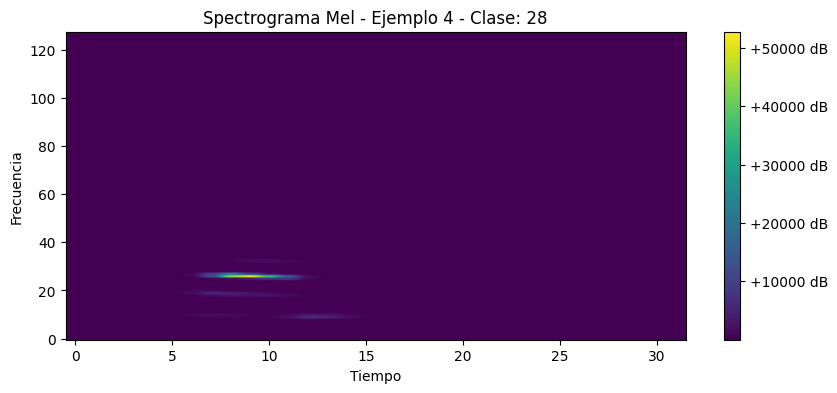

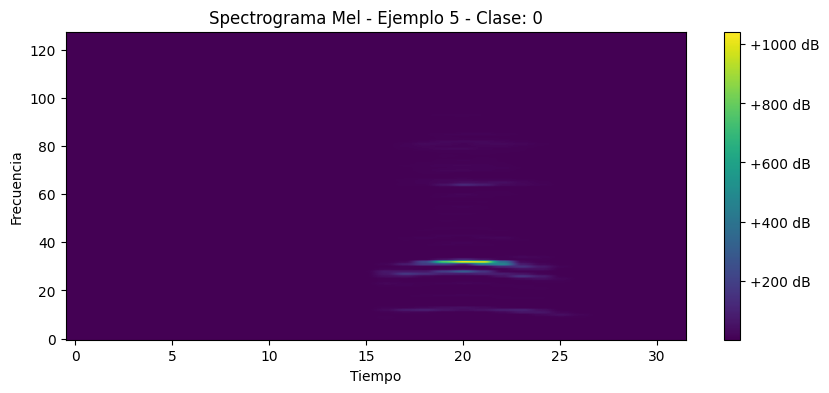

In [28]:
# Dataloader de validacion
plot_batch_mel_spectrograms(val_dl, num_samples=5)

### Definimos las funciones necesarias para el entrenamiento

In [22]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
  estado_modelo = {'epoch': epoca,
                   'model_state_dict': modelo.state_dict(),
                   'optimizer_state_dict': opt.state_dict()}
  torch.save(estado_modelo, ckptpath)

In [23]:
from torch.utils.tensorboard import SummaryWriter

def registra_info_tboard(writer, epoca, hist):
  for (m,v) in hist.items():
    writer.add_scalar(m, v[epoca], epoca)

In [24]:
def exactitud(y_hat, y):
  cmp = y_hat.argmax(dim=-1) == y
  aciertos = torch.count_nonzero(cmp)
  return aciertos / cmp.shape[0]

In [25]:
def paso_ent(modelo,
             fp,
             metrica,
             opt,
             X,
             y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with torch.no_grad():
    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
    metricas_paso = metrica(y_hat, y)

  return perdida_paso, metricas_paso

In [26]:
def entrena(modelo, fp, metrica, opt, scheduler, entdl, valdl, disp, ckptpath, n_epocas=10, tbdir='runs/'):
    n_lotes_ent = len(entdl)
    n_lotes_val = len(valdl)

    hist = {'perdida_ent': np.zeros(n_epocas),
            'perdida_val': np.zeros(n_epocas),
            metrica.__name__ + '_ent': np.zeros(n_epocas),
            metrica.__name__ + '_val': np.zeros(n_epocas)}

    tbwriter = SummaryWriter(tbdir)
    perdida_min = torch.inf
    mejor_modelo = copy.deepcopy(modelo)

    for e in range(n_epocas):
        modelo.train()
        progreso_ent = tqdm(entdl, desc=f'Época {e + 1}/{n_epocas}', leave=False)
        for p, (Xlote, ylote) in enumerate(progreso_ent):
            Xlote = Xlote.to(disp)
            ylote = ylote.to(disp)

            perdida_paso, metrica_paso = paso_ent(modelo, fp, metrica, opt, Xlote, ylote)

            hist['perdida_ent'][e] += perdida_paso.item()
            hist[metrica.__name__ + '_ent'][e] += metrica_paso

            progreso_ent.set_postfix({
                'Perdida(E)': f'{hist["perdida_ent"][e]/(p+1):.4f}',
                f'{metrica.__name__}(E)': f'{hist[metrica.__name__ + "_ent"][e]/(p+1):.4f}'
            })

        modelo.eval()
        progreso_val = tqdm(valdl, desc='Validación', leave=False)
        with torch.no_grad():
            for p, (Xlote, ylote) in enumerate(progreso_val):
                Xlote = Xlote.to(disp)
                ylote = ylote.to(disp)

                y_hat = modelo(Xlote)

                perdida_val_paso = fp(y_hat, ylote).item()
                metrica_val_paso = metrica(y_hat, ylote)

                hist['perdida_val'][e] += perdida_val_paso
                hist[metrica.__name__ + '_val'][e] += metrica_val_paso

                progreso_val.set_postfix({
                    'Perdida(V)': f'{hist["perdida_val"][e]/(p+1):.4f}',
                    f'{metrica.__name__}(V)': f'{hist[metrica.__name__ + "_val"][e]/(p+1):.4f}'
                })

        hist['perdida_ent'][e] /= n_lotes_ent
        hist[metrica.__name__ + '_ent'][e] /= n_lotes_ent
        hist['perdida_val'][e] /= n_lotes_val
        hist[metrica.__name__ + '_val'][e] /= n_lotes_val

        if hist['perdida_val'][e] < perdida_min:
            mejor_modelo.load_state_dict(modelo.state_dict())
            guarda_ckpt(ckptpath, modelo, e, opt)
            perdida_min = hist['perdida_val'][e]

        # Actualizar el scheduler basado en la pérdida de validación
        scheduler.step(hist['perdida_val'][e])
        lr = scheduler.optimizer.param_groups[0]['lr']
        # Registrar los valores en TensorBoard
        registra_info_tboard(tbwriter, e, hist)

        print(f'\nÉpoca {e + 1}/{n_epocas}: '
              f'Perdida(E) = {hist["perdida_ent"][e]:.4f}, '
              f'{metrica.__name__}(E) = {hist[metrica.__name__ + "_ent"][e]:.4f}, '
              f'Perdida(V) = {hist["perdida_val"][e]:.4f}, '
              f'{metrica.__name__}(V) = {hist[metrica.__name__ + "_val"][e]:.4f}',
              f"Tasa de aprendizaje en la época {e+1}: {lr}")

    return modelo, mejor_modelo, hist

In [27]:
# Obtener el número de muestras por clase
class_counts = train_dataset_img.files_df['labels'].value_counts().sort_index().values

# Calcular los pesos inversamente proporcionales a la frecuencia
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()  # Normalizar para que sumen 1
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

## CONVOLUCIÓN EN 1D

### Para la convolución en 1D tomamos como base la ConvNeXt modificando las convoluciones 2D por 1D
### Para esto debemos de iterar a través de filas o columnas para poder realizar la convolución en una imagen que es una matriz de dos dimensiones

In [33]:
class ConvNeXtRes1D(nn.Module):
    def __init__(self, in_chan, out_chan, downsample=False, drop_path=0.):
        super(ConvNeXtRes1D, self).__init__()
        stride = 2 if downsample else 1

        # Conv1x1 para ajustar el tamaño en caso de ser necesario
        if in_chan != out_chan or downsample:
            self.conv1x1 = nn.Conv1d(in_chan, out_chan, kernel_size=1, stride=stride)
        else:
            self.conv1x1 = None

        # Definición de la estructura 
        self.conv1 = nn.Conv1d(in_chan, out_chan, kernel_size=7, stride=stride, padding=3)
        self.ln = nn.LayerNorm(out_chan, eps=1e-6)
        self.conv2 = nn.Conv1d(out_chan, out_chan * 4, kernel_size=1)
        self.GeLU = nn.GELU()
        self.conv3 = nn.Conv1d(out_chan * 4, out_chan, kernel_size=1)
        self.gamma = nn.Parameter(1e-6 * torch.ones((out_chan)), requires_grad=True)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        if x.dim() == 4:
            # x tiene shape [batch_size, channels, height, width]
            batch_size, in_channels, height, width = x.shape

            # Reshape x a [batch_size, channels, length]
            x = x.view(batch_size, in_channels, height * width)
            length = height * width
        elif x.dim() == 3:
            # x tiene shape [batch_size, channels, length]
            batch_size, in_channels, length = x.shape
        else:
            raise ValueError("Input tensor must be 3D or 4D")

        # Primera convolución
        y = self.conv1(x)  # [batch_size, out_channels, new_length]

        # Aplicar LayerNom
        y = y.permute(0, 2, 1)  # [batch_size, new_length, out_channels]
        y = self.ln(y)
        y = y.permute(0, 2, 1)  # [batch_size, out_channels, new_length]

        # Segunda convolución seguida de la función de activación GeLU
        y = self.conv2(y)
        y = self.GeLU(y)
        # Tercera convolución
        y = self.conv3(y)

        # Aplicar el tensor de parámetros aprendibles
        y = y * self.gamma[:, None]

        # Ajustar los canales con conv1x1 en caso de ser necesario
        if self.conv1x1:
            x = self.conv1x1(x)

        # Suma residual con dropout
        return x + self.drop_path(y)

In [34]:
res = ConvNeXtRes1D(3, 16, drop_path=0.5)
output = res(torch.randn(1, 3, 64, 64)) #Se realiza la prueba con un tensor bidimensional
print(output.shape)

torch.Size([1, 16, 4096])


In [35]:
class ConvNeXtBloq1D(nn.Module):
    def __init__(self, in_channels, out_channels, k=2, downsample=False, drop_p_list=None):
        super(ConvNeXtBloq1D, self).__init__()

        if drop_p_list is None:
            drop_p_list = [0.0] * k  # Si no se proporciona, se asume 0.0 para todos los bloques
        assert len(drop_p_list) == k, "La longitud de drop_p_list debe ser igual a k"

        self.res = []
        # Primer bloque (puede aplicar downsampling)
        self.res.append(ConvNeXtRes1D(in_channels, out_channels, downsample=downsample, drop_path=drop_p_list[0]))

        # Bloques siguientes
        for i in range(1, k):
            self.res.append(ConvNeXtRes1D(out_channels, out_channels, drop_path=drop_p_list[i]))
        self.res = nn.ModuleList(self.res)

    def forward(self, x):
        for layer in self.res:
            x = layer(x)
        return x

In [36]:
b = ConvNeXtBloq1D(1, 6)
print(b(torch.rand(1, 1, 64, 64)).shape)

torch.Size([1, 6, 4096])


In [37]:
class ConvNeXt181D(nn.Module):
    def __init__(self, in_channels, n_classes, drop_path_rate=0.1):
        super(ConvNeXt181D, self).__init__()
        self.in_channels = in_channels

        # Ajustar la capa de entrada para que sea compatible con Conv1D
        self.conv1 = nn.Conv1d(self.in_channels, 64, kernel_size=4, stride=4)
        self.ln = nn.LayerNorm(64, eps=1e-6)

        # Definir las profundidades de los bloques
        depths = [2, 2, 2, 2]  # Número de bloques en cada etapa (Similar a la ResNet18)
        total_blocks = sum(depths)

        # Generar las tasas de drop_path para cada bloque
        drop_rates = [x.item() for x in torch.linspace(0, drop_path_rate, total_blocks)]

        # Índice para rastrear la posición en drop_rates
        idx = 0

        # Bloque 1
        drop_p_list_b1 = drop_rates[idx:idx+depths[0]]
        idx += depths[0]
        self.b1 = ConvNeXtBloq1D(64, 64, k=depths[0], drop_p_list=drop_p_list_b1)

        # Bloque 2
        drop_p_list_b2 = drop_rates[idx:idx+depths[1]]
        idx += depths[1]
        self.b2 = ConvNeXtBloq1D(64, 128, k=depths[1], downsample=True, drop_p_list=drop_p_list_b2)

        # Bloque 3
        drop_p_list_b3 = drop_rates[idx:idx+depths[2]]
        idx += depths[2]
        self.b3 = ConvNeXtBloq1D(128, 256, k=depths[2], downsample=True, drop_p_list=drop_p_list_b3)

        # Bloque 4
        drop_p_list_b4 = drop_rates[idx:idx+depths[3]]
        self.b4 = ConvNeXtBloq1D(256, 512, k=depths[3], downsample=True, drop_p_list=drop_p_list_b4)

        # Ajustar la capa de pooling y la capa final
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.norm = nn.LayerNorm(512, eps=1e-6)
        self.fc = nn.Linear(512, n_classes)

    def forward(self, x):
        # x: [batch_size, channels, height, width]

        batch_size, channels, height, width = x.shape

        # Combinar las dimensiones de height y width para aplicar Conv1D
        x = x.view(batch_size, channels, height * width)  # [batch_size, channels, height * width]

        # Aplicar la primera convolución 1D
        x = self.conv1(x)  # [batch_size, 64, nueva_longitud]
        x = x.permute(0, 2, 1)  # [batch_size, nueva_longitud, 64]
        x = self.ln(x)
        x = x.permute(0, 2, 1)  # [batch_size, 64, nueva_longitud]

        # Pasar por los bloques
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)

        # Aplicar Global Average Pooling
        x = self.gap(x)  # [batch_size, 512, 1]
        x = x.view(batch_size, -1)  # [batch_size, 512]
        x = self.norm(x)
        x = self.fc(x)  # [batch_size, n_classes]

        return x

In [38]:
b = ConvNeXt181D(in_channels=1, n_classes=7, drop_path_rate=0.1).to(device)
print(b(torch.rand(1, 1, 96, 96).to(device)).shape)

torch.Size([1, 7])


In [39]:
current_dir = Path.cwd()
LOGDIR = current_dir / 'logs' / 'Audio_imagen' / 'Conv1D'
ckptpath = LOGDIR / 'ConvNeXt181D_audio.pt'
num_classes = train_df['labels'].nunique() # Número de clases

ConvNeXt1D = ConvNeXt181D(in_channels=1, n_classes=num_classes, drop_path_rate=0.4).to(device)

perdida1d = nn.CrossEntropyLoss(weight=class_weights,
                              reduction='mean',
                              label_smoothing=0.03)

opt1d = AdamW(ConvNeXt1D.parameters(),
           lr=0.0001,
            weight_decay=1e-4)

scheduler1d = ReduceLROnPlateau(opt1d, mode='min', factor=0.1, patience=8)

ConvNeXt1D, mejor_lenet, hist1d = entrena(ConvNeXt1D,
                                   perdida1d,
                                   exactitud,
                                   opt1d,
                                   scheduler1d,
                                   train_dl,
                                   val_dl,
                                   device,
                                   ckptpath,                                  
                                   n_epocas=50,
                                   tbdir = LOGDIR)


Época 1/50: Perdida(E) = 3.4092, exactitud(E) = 0.0377, Perdida(V) = 3.3838, exactitud(V) = 0.0468 Tasa de aprendizaje en la época 1: 0.0001



Época 2/50: Perdida(E) = 3.3358, exactitud(E) = 0.0605, Perdida(V) = 3.2486, exactitud(V) = 0.0854 Tasa de aprendizaje en la época 2: 0.0001



Época 3/50: Perdida(E) = 3.2264, exactitud(E) = 0.0889, Perdida(V) = 3.1471, exactitud(V) = 0.1235 Tasa de aprendizaje en la época 3: 0.0001



Época 4/50: Perdida(E) = 3.1299, exactitud(E) = 0.1120, Perdida(V) = 3.0123, exactitud(V) = 0.1560 Tasa de aprendizaje en la época 4: 0.0001



Época 5/50: Perdida(E) = 3.0443, exactitud(E) = 0.1339, Perdida(V) = 2.9693, exactitud(V) = 0.1578 Tasa de aprendizaje en la época 5: 0.0001



Época 6/50: Perdida(E) = 2.9739, exactitud(E) = 0.1528, Perdida(V) = 2.8515, exactitud(V) = 0.1933 Tasa de aprendizaje en la época 6: 0.0001



Época 7/50: Perdida(E) = 2.9032, exactitud(E) = 0.1730, Perdida(V) = 2.7490, exactitud(V) = 0.2283 Tasa de aprendizaje en la época 7: 0.0001



Época 8/50: Perdida(E) = 2.8310, exactitud(E) = 0.1944, Perdida(V) = 2.6996, exactitud(V) = 0.2294 Tasa de aprendizaje en la época 8: 0.0001



Época 9/50: Perdida(E) = 2.7749, exactitud(E) = 0.2124, Perdida(V) = 2.6287, exactitud(V) = 0.2535 Tasa de aprendizaje en la época 9: 0.0001



Época 10/50: Perdida(E) = 2.7070, exactitud(E) = 0.2303, Perdida(V) = 2.5217, exactitud(V) = 0.2873 Tasa de aprendizaje en la época 10: 0.0001



Época 11/50: Perdida(E) = 2.6491, exactitud(E) = 0.2479, Perdida(V) = 2.4074, exactitud(V) = 0.3271 Tasa de aprendizaje en la época 11: 0.0001



Época 12/50: Perdida(E) = 2.5764, exactitud(E) = 0.2696, Perdida(V) = 2.3287, exactitud(V) = 0.3445 Tasa de aprendizaje en la época 12: 0.0001



Época 13/50: Perdida(E) = 2.5152, exactitud(E) = 0.2876, Perdida(V) = 2.2480, exactitud(V) = 0.3791 Tasa de aprendizaje en la época 13: 0.0001



Época 14/50: Perdida(E) = 2.4534, exactitud(E) = 0.3053, Perdida(V) = 2.1611, exactitud(V) = 0.3987 Tasa de aprendizaje en la época 14: 0.0001



Época 15/50: Perdida(E) = 2.3941, exactitud(E) = 0.3244, Perdida(V) = 2.1346, exactitud(V) = 0.4071 Tasa de aprendizaje en la época 15: 0.0001



Época 16/50: Perdida(E) = 2.3453, exactitud(E) = 0.3398, Perdida(V) = 2.0146, exactitud(V) = 0.4462 Tasa de aprendizaje en la época 16: 0.0001



Época 17/50: Perdida(E) = 2.2840, exactitud(E) = 0.3597, Perdida(V) = 1.9685, exactitud(V) = 0.4614 Tasa de aprendizaje en la época 17: 0.0001



Época 18/50: Perdida(E) = 2.2332, exactitud(E) = 0.3742, Perdida(V) = 1.8899, exactitud(V) = 0.4881 Tasa de aprendizaje en la época 18: 0.0001



Época 19/50: Perdida(E) = 2.1693, exactitud(E) = 0.3915, Perdida(V) = 1.8160, exactitud(V) = 0.5028 Tasa de aprendizaje en la época 19: 0.0001



Época 20/50: Perdida(E) = 2.1315, exactitud(E) = 0.4065, Perdida(V) = 1.7541, exactitud(V) = 0.5312 Tasa de aprendizaje en la época 20: 0.0001



Época 21/50: Perdida(E) = 2.0799, exactitud(E) = 0.4251, Perdida(V) = 1.7034, exactitud(V) = 0.5411 Tasa de aprendizaje en la época 21: 0.0001



Época 22/50: Perdida(E) = 2.0333, exactitud(E) = 0.4359, Perdida(V) = 1.6684, exactitud(V) = 0.5552 Tasa de aprendizaje en la época 22: 0.0001



Época 23/50: Perdida(E) = 1.9891, exactitud(E) = 0.4493, Perdida(V) = 1.6250, exactitud(V) = 0.5683 Tasa de aprendizaje en la época 23: 0.0001



Época 24/50: Perdida(E) = 1.9445, exactitud(E) = 0.4627, Perdida(V) = 1.5884, exactitud(V) = 0.5807 Tasa de aprendizaje en la época 24: 0.0001



Época 25/50: Perdida(E) = 1.9036, exactitud(E) = 0.4754, Perdida(V) = 1.5288, exactitud(V) = 0.5957 Tasa de aprendizaje en la época 25: 0.0001



Época 26/50: Perdida(E) = 1.8744, exactitud(E) = 0.4843, Perdida(V) = 1.4757, exactitud(V) = 0.6146 Tasa de aprendizaje en la época 26: 0.0001



Época 27/50: Perdida(E) = 1.8403, exactitud(E) = 0.4947, Perdida(V) = 1.4363, exactitud(V) = 0.6293 Tasa de aprendizaje en la época 27: 0.0001



Época 28/50: Perdida(E) = 1.8043, exactitud(E) = 0.5067, Perdida(V) = 1.4088, exactitud(V) = 0.6344 Tasa de aprendizaje en la época 28: 0.0001



Época 29/50: Perdida(E) = 1.7715, exactitud(E) = 0.5167, Perdida(V) = 1.3721, exactitud(V) = 0.6438 Tasa de aprendizaje en la época 29: 0.0001



Época 30/50: Perdida(E) = 1.7436, exactitud(E) = 0.5289, Perdida(V) = 1.3320, exactitud(V) = 0.6640 Tasa de aprendizaje en la época 30: 0.0001



Época 31/50: Perdida(E) = 1.7032, exactitud(E) = 0.5391, Perdida(V) = 1.3237, exactitud(V) = 0.6675 Tasa de aprendizaje en la época 31: 0.0001



Época 32/50: Perdida(E) = 1.6741, exactitud(E) = 0.5487, Perdida(V) = 1.2637, exactitud(V) = 0.6851 Tasa de aprendizaje en la época 32: 0.0001



Época 33/50: Perdida(E) = 1.6472, exactitud(E) = 0.5576, Perdida(V) = 1.2351, exactitud(V) = 0.6928 Tasa de aprendizaje en la época 33: 0.0001



Época 34/50: Perdida(E) = 1.6191, exactitud(E) = 0.5637, Perdida(V) = 1.2248, exactitud(V) = 0.6899 Tasa de aprendizaje en la época 34: 0.0001



Época 35/50: Perdida(E) = 1.5969, exactitud(E) = 0.5747, Perdida(V) = 1.2261, exactitud(V) = 0.6958 Tasa de aprendizaje en la época 35: 0.0001



Época 36/50: Perdida(E) = 1.5683, exactitud(E) = 0.5843, Perdida(V) = 1.1748, exactitud(V) = 0.7125 Tasa de aprendizaje en la época 36: 0.0001



Época 37/50: Perdida(E) = 1.5423, exactitud(E) = 0.5918, Perdida(V) = 1.1503, exactitud(V) = 0.7253 Tasa de aprendizaje en la época 37: 0.0001



Época 38/50: Perdida(E) = 1.5240, exactitud(E) = 0.5990, Perdida(V) = 1.1256, exactitud(V) = 0.7276 Tasa de aprendizaje en la época 38: 0.0001



Época 39/50: Perdida(E) = 1.4958, exactitud(E) = 0.6061, Perdida(V) = 1.1063, exactitud(V) = 0.7320 Tasa de aprendizaje en la época 39: 0.0001



Época 40/50: Perdida(E) = 1.4793, exactitud(E) = 0.6110, Perdida(V) = 1.1016, exactitud(V) = 0.7344 Tasa de aprendizaje en la época 40: 0.0001



Época 41/50: Perdida(E) = 1.4538, exactitud(E) = 0.6200, Perdida(V) = 1.0790, exactitud(V) = 0.7404 Tasa de aprendizaje en la época 41: 0.0001



Época 42/50: Perdida(E) = 1.4315, exactitud(E) = 0.6261, Perdida(V) = 1.0542, exactitud(V) = 0.7521 Tasa de aprendizaje en la época 42: 0.0001



Época 43/50: Perdida(E) = 1.4140, exactitud(E) = 0.6321, Perdida(V) = 1.0028, exactitud(V) = 0.7716 Tasa de aprendizaje en la época 43: 0.0001



Época 44/50: Perdida(E) = 1.3941, exactitud(E) = 0.6393, Perdida(V) = 1.0318, exactitud(V) = 0.7574 Tasa de aprendizaje en la época 44: 0.0001



Época 45/50: Perdida(E) = 1.3757, exactitud(E) = 0.6446, Perdida(V) = 1.0130, exactitud(V) = 0.7655 Tasa de aprendizaje en la época 45: 0.0001



Época 46/50: Perdida(E) = 1.3671, exactitud(E) = 0.6502, Perdida(V) = 0.9780, exactitud(V) = 0.7781 Tasa de aprendizaje en la época 46: 0.0001



Época 47/50: Perdida(E) = 1.3510, exactitud(E) = 0.6523, Perdida(V) = 0.9825, exactitud(V) = 0.7785 Tasa de aprendizaje en la época 47: 0.0001



Época 48/50: Perdida(E) = 1.3260, exactitud(E) = 0.6601, Perdida(V) = 0.9613, exactitud(V) = 0.7837 Tasa de aprendizaje en la época 48: 0.0001



Época 49/50: Perdida(E) = 1.3097, exactitud(E) = 0.6682, Perdida(V) = 0.9695, exactitud(V) = 0.7744 Tasa de aprendizaje en la época 49: 0.0001



Época 50/50: Perdida(E) = 1.2950, exactitud(E) = 0.6726, Perdida(V) = 0.9447, exactitud(V) = 0.7914 Tasa de aprendizaje en la época 50: 0.0001


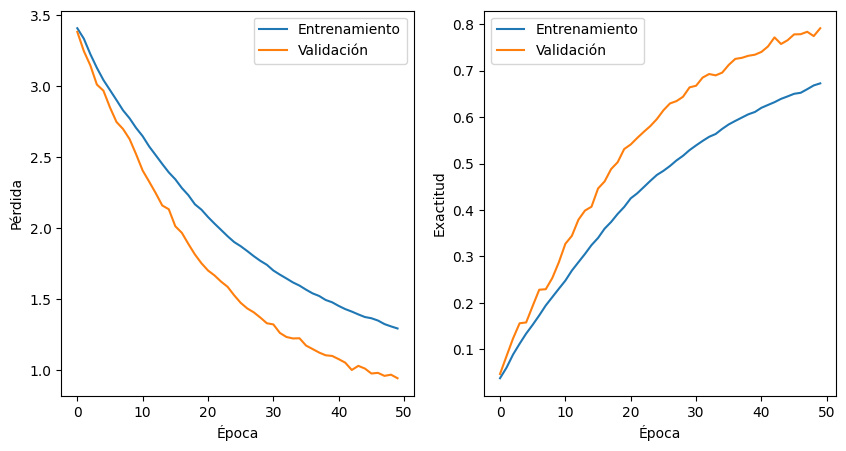

In [40]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist1d['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist1d['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist1d['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist1d['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

## CONVOLUCIÓN EN 2D 

In [40]:
class ConvNeXtRes(nn.Module):
  def __init__(self, in_chan, out_chan, downsample = False, drop_path = 0.):
    super(ConvNeXtRes, self).__init__()
    stride = 1
    if downsample:
      stride =2 
    
    if in_chan != out_chan or downsample:
      self.conv1x1 = nn.Conv2d(in_chan, out_chan, 1, stride = stride)
    else: 
      self.conv1x1 = None
    
    self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size= 7, stride= stride, padding= 3)
    self.ln = nn.LayerNorm(out_chan, eps=1e-6)
    self.conv2 = nn.Conv2d(out_chan, out_chan * 4, kernel_size= 1)
    self.GeLU = nn.GELU()
    self.conv3 = nn.Conv2d(out_chan * 4, out_chan, kernel_size = 1)
    self.gamma = nn.Parameter(1e-6 * torch.ones((out_chan)), requires_grad=True) #tensor de parámetros aprendibles
    self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity() #Activación o desactivación de rutas (similar a droput en MLP)

  def forward(self, x):
  
      # Convolución 1
      y = self.conv1(x)
      # LayerNorm espera la forma (batch_size, height, width, channels)
      y = y.permute(0, 2, 3, 1)
      y = self.ln(y)
      y = y.permute(0, 3, 1, 2)
      #Convolucion 2
      y = self.conv2(y)
      y = self.GeLU(y)
      #Convolucion 3 
      y = self.conv3(y)
      #Aplicar gamma 
      y = self.gamma[:, None, None] * y
      
      #Conexion residual 
      if self.conv1x1:
        x = self.conv1x1(x)
      
      return x + self.drop_path(y) 
    
class ConvNeXtBloq(nn.Module):
    def __init__(self, in_channels, out_channels, k=2, downsample=False, drop_p_list=None):
        super(ConvNeXtBloq, self).__init__()

        if drop_p_list is None:
            drop_p_list = [0.0] * k  # Si no se proporciona, se asume 0.0 para todos los bloques
        assert len(drop_p_list) == k, "La longitud de drop_p_list debe ser igual a k"

        self.res = []
        # Primer bloque (puede aplicar downsampling)
        self.res.append(ConvNeXtRes(in_channels, out_channels, downsample=downsample, drop_path=drop_p_list[0]))

        # Bloques siguientes
        for i in range(1, k):
            self.res.append(ConvNeXtRes(out_channels, out_channels, drop_path=drop_p_list[i]))
        self.res = nn.ModuleList(self.res)

    def forward(self, x):
        for layer in self.res:
            x = layer(x)
        return x
    
class ConvNeXt18(nn.Module):
    def __init__(self, in_channels, n_clases, drop_path_rate=0.1):
        super(ConvNeXt18, self).__init__()
        self.in_channels = in_channels
        self.conv1 = nn.Conv2d(self.in_channels, 64, kernel_size=4, stride=4)
        self.ln = nn.LayerNorm(64, eps=1e-6)

        # Definir las profundidades de los bloques
        depths = [2, 2, 2, 2]  # Número de bloques en cada etapa (Similar a la ResNet18)
        total_blocks = sum(depths)
        # Generar las tasas de drop_path para cada bloque
        drop_rates = [x.item() for x in torch.linspace(0, drop_path_rate, total_blocks)]

        # Índice para rastrear la posición en drop_rates
        idx = 0

        # Bloque 1 (siguiendo el tamaño de ResNet18)
        drop_p_list_b1 = drop_rates[idx:idx+depths[0]]
        idx += depths[0]
        self.b1 = ConvNeXtBloq(64, 64, k=depths[0], drop_p_list=drop_p_list_b1)

        # Bloque 2
        drop_p_list_b2 = drop_rates[idx:idx+depths[1]]
        idx += depths[1]
        self.b2 = ConvNeXtBloq(64, 128, k=depths[1], downsample=True, drop_p_list=drop_p_list_b2)

        # Bloque 3
        drop_p_list_b3 = drop_rates[idx:idx+depths[2]]
        idx += depths[2]
        self.b3 = ConvNeXtBloq(128, 256, k=depths[2], downsample=True, drop_p_list=drop_p_list_b3)

        # Bloque 4
        drop_p_list_b4 = drop_rates[idx:idx+depths[3]]
        self.b4 = ConvNeXtBloq(256, 512, k=depths[3], downsample=True, drop_p_list=drop_p_list_b4)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.nom = nn.LayerNorm(512, eps = 1e-6)
        self.densa = nn.Linear(512, n_clases)

    def forward(self, x):
        x = self.conv1(x)
        x = self.ln(x.permute(0, 2, 3, 1))
        x = x.permute(0, 3, 1, 2)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.gap(x)
        x = x.flatten(start_dim=1)
        x = self.nom(x)
        x = self.densa(x)
        return x

In [47]:
current_dir = Path.cwd()
LOGDIR = current_dir / 'logs' / 'Audio_imagen'
ckptpath = LOGDIR / 'ConvNeXt18_audio.pt'
num_classes = train_df['labels'].nunique() # Número de clases

ConvNeXt = ConvNeXt18(in_channels=1, n_clases=num_classes, drop_path_rate=0.4).to(device)

perdida = nn.CrossEntropyLoss(weight=class_weights,
                              reduction='mean',
                              label_smoothing=0.03)

opt = AdamW(ConvNeXt.parameters(),
           lr=0.0001,
            weight_decay=1e-4)

scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=8)

ConvNeXt, mejor_lenet, hist = entrena(ConvNeXt,
                                   perdida,
                                   exactitud,
                                   opt,
                                   scheduler,
                                   train_dl,
                                   val_dl,
                                   device,
                                   ckptpath,                                  
                                   n_epocas=50,
                                   tbdir = LOGDIR)


Época 1/50: Perdida(E) = 3.3627, exactitud(E) = 0.0522, Perdida(V) = 3.0884, exactitud(V) = 0.1204 Tasa de aprendizaje en la época 1: 0.0001



Época 2/50: Perdida(E) = 2.8633, exactitud(E) = 0.1720, Perdida(V) = 2.2102, exactitud(V) = 0.3723 Tasa de aprendizaje en la época 2: 0.0001



Época 3/50: Perdida(E) = 2.2611, exactitud(E) = 0.3540, Perdida(V) = 1.6992, exactitud(V) = 0.5389 Tasa de aprendizaje en la época 3: 0.0001



Época 4/50: Perdida(E) = 1.8977, exactitud(E) = 0.4716, Perdida(V) = 1.4742, exactitud(V) = 0.6143 Tasa de aprendizaje en la época 4: 0.0001



Época 5/50: Perdida(E) = 1.6754, exactitud(E) = 0.5428, Perdida(V) = 1.3265, exactitud(V) = 0.6564 Tasa de aprendizaje en la época 5: 0.0001



Época 6/50: Perdida(E) = 1.5276, exactitud(E) = 0.5896, Perdida(V) = 1.2006, exactitud(V) = 0.7038 Tasa de aprendizaje en la época 6: 0.0001



Época 7/50: Perdida(E) = 1.4132, exactitud(E) = 0.6280, Perdida(V) = 1.1093, exactitud(V) = 0.7308 Tasa de aprendizaje en la época 7: 0.0001



Época 8/50: Perdida(E) = 1.3131, exactitud(E) = 0.6596, Perdida(V) = 1.0583, exactitud(V) = 0.7486 Tasa de aprendizaje en la época 8: 0.0001



Época 9/50: Perdida(E) = 1.2366, exactitud(E) = 0.6863, Perdida(V) = 0.9847, exactitud(V) = 0.7720 Tasa de aprendizaje en la época 9: 0.0001



Época 10/50: Perdida(E) = 1.1737, exactitud(E) = 0.7040, Perdida(V) = 0.9584, exactitud(V) = 0.7743 Tasa de aprendizaje en la época 10: 0.0001



Época 11/50: Perdida(E) = 1.1107, exactitud(E) = 0.7261, Perdida(V) = 0.9038, exactitud(V) = 0.7969 Tasa de aprendizaje en la época 11: 0.0001



Época 12/50: Perdida(E) = 1.0655, exactitud(E) = 0.7393, Perdida(V) = 0.8842, exactitud(V) = 0.8028 Tasa de aprendizaje en la época 12: 0.0001



Época 13/50: Perdida(E) = 1.0200, exactitud(E) = 0.7541, Perdida(V) = 0.8558, exactitud(V) = 0.8109 Tasa de aprendizaje en la época 13: 0.0001



Época 14/50: Perdida(E) = 0.9768, exactitud(E) = 0.7697, Perdida(V) = 0.8391, exactitud(V) = 0.8179 Tasa de aprendizaje en la época 14: 0.0001



Época 15/50: Perdida(E) = 0.9444, exactitud(E) = 0.7803, Perdida(V) = 0.7970, exactitud(V) = 0.8312 Tasa de aprendizaje en la época 15: 0.0001



Época 16/50: Perdida(E) = 0.9111, exactitud(E) = 0.7892, Perdida(V) = 0.7926, exactitud(V) = 0.8297 Tasa de aprendizaje en la época 16: 0.0001



Época 17/50: Perdida(E) = 0.8775, exactitud(E) = 0.8001, Perdida(V) = 0.7676, exactitud(V) = 0.8354 Tasa de aprendizaje en la época 17: 0.0001



Época 18/50: Perdida(E) = 0.8533, exactitud(E) = 0.8081, Perdida(V) = 0.7434, exactitud(V) = 0.8464 Tasa de aprendizaje en la época 18: 0.0001



Época 19/50: Perdida(E) = 0.8212, exactitud(E) = 0.8180, Perdida(V) = 0.7295, exactitud(V) = 0.8475 Tasa de aprendizaje en la época 19: 0.0001



Época 20/50: Perdida(E) = 0.8016, exactitud(E) = 0.8237, Perdida(V) = 0.7159, exactitud(V) = 0.8531 Tasa de aprendizaje en la época 20: 0.0001



Época 21/50: Perdida(E) = 0.7746, exactitud(E) = 0.8317, Perdida(V) = 0.7154, exactitud(V) = 0.8543 Tasa de aprendizaje en la época 21: 0.0001



Época 22/50: Perdida(E) = 0.7564, exactitud(E) = 0.8409, Perdida(V) = 0.6945, exactitud(V) = 0.8605 Tasa de aprendizaje en la época 22: 0.0001



Época 23/50: Perdida(E) = 0.7346, exactitud(E) = 0.8461, Perdida(V) = 0.6943, exactitud(V) = 0.8622 Tasa de aprendizaje en la época 23: 0.0001



Época 24/50: Perdida(E) = 0.7172, exactitud(E) = 0.8521, Perdida(V) = 0.6666, exactitud(V) = 0.8712 Tasa de aprendizaje en la época 24: 0.0001



Época 25/50: Perdida(E) = 0.6929, exactitud(E) = 0.8611, Perdida(V) = 0.6608, exactitud(V) = 0.8730 Tasa de aprendizaje en la época 25: 0.0001



Época 26/50: Perdida(E) = 0.6796, exactitud(E) = 0.8635, Perdida(V) = 0.6593, exactitud(V) = 0.8766 Tasa de aprendizaje en la época 26: 0.0001



Época 27/50: Perdida(E) = 0.6655, exactitud(E) = 0.8696, Perdida(V) = 0.6654, exactitud(V) = 0.8729 Tasa de aprendizaje en la época 27: 0.0001



Época 28/50: Perdida(E) = 0.6482, exactitud(E) = 0.8743, Perdida(V) = 0.6461, exactitud(V) = 0.8755 Tasa de aprendizaje en la época 28: 0.0001



Época 29/50: Perdida(E) = 0.6355, exactitud(E) = 0.8784, Perdida(V) = 0.6427, exactitud(V) = 0.8802 Tasa de aprendizaje en la época 29: 0.0001



Época 30/50: Perdida(E) = 0.6178, exactitud(E) = 0.8843, Perdida(V) = 0.6319, exactitud(V) = 0.8829 Tasa de aprendizaje en la época 30: 0.0001



Época 31/50: Perdida(E) = 0.6086, exactitud(E) = 0.8888, Perdida(V) = 0.6276, exactitud(V) = 0.8848 Tasa de aprendizaje en la época 31: 0.0001



Época 32/50: Perdida(E) = 0.5933, exactitud(E) = 0.8926, Perdida(V) = 0.6186, exactitud(V) = 0.8862 Tasa de aprendizaje en la época 32: 0.0001



Época 33/50: Perdida(E) = 0.5831, exactitud(E) = 0.8955, Perdida(V) = 0.6226, exactitud(V) = 0.8856 Tasa de aprendizaje en la época 33: 0.0001



Época 34/50: Perdida(E) = 0.5727, exactitud(E) = 0.8999, Perdida(V) = 0.6338, exactitud(V) = 0.8829 Tasa de aprendizaje en la época 34: 0.0001



Época 35/50: Perdida(E) = 0.5579, exactitud(E) = 0.9054, Perdida(V) = 0.6039, exactitud(V) = 0.8913 Tasa de aprendizaje en la época 35: 0.0001



Época 36/50: Perdida(E) = 0.5494, exactitud(E) = 0.9081, Perdida(V) = 0.6156, exactitud(V) = 0.8893 Tasa de aprendizaje en la época 36: 0.0001



Época 37/50: Perdida(E) = 0.5370, exactitud(E) = 0.9126, Perdida(V) = 0.6242, exactitud(V) = 0.8838 Tasa de aprendizaje en la época 37: 0.0001



Época 38/50: Perdida(E) = 0.5327, exactitud(E) = 0.9144, Perdida(V) = 0.6043, exactitud(V) = 0.8933 Tasa de aprendizaje en la época 38: 0.0001



Época 39/50: Perdida(E) = 0.5216, exactitud(E) = 0.9180, Perdida(V) = 0.6005, exactitud(V) = 0.8944 Tasa de aprendizaje en la época 39: 0.0001



Época 40/50: Perdida(E) = 0.5132, exactitud(E) = 0.9199, Perdida(V) = 0.6010, exactitud(V) = 0.8941 Tasa de aprendizaje en la época 40: 0.0001



Época 41/50: Perdida(E) = 0.5048, exactitud(E) = 0.9220, Perdida(V) = 0.5972, exactitud(V) = 0.8954 Tasa de aprendizaje en la época 41: 0.0001



Época 42/50: Perdida(E) = 0.5009, exactitud(E) = 0.9237, Perdida(V) = 0.5919, exactitud(V) = 0.8966 Tasa de aprendizaje en la época 42: 0.0001



Época 43/50: Perdida(E) = 0.4885, exactitud(E) = 0.9271, Perdida(V) = 0.5925, exactitud(V) = 0.8979 Tasa de aprendizaje en la época 43: 0.0001



Época 44/50: Perdida(E) = 0.4825, exactitud(E) = 0.9290, Perdida(V) = 0.5916, exactitud(V) = 0.8989 Tasa de aprendizaje en la época 44: 0.0001



Época 45/50: Perdida(E) = 0.4770, exactitud(E) = 0.9318, Perdida(V) = 0.5890, exactitud(V) = 0.8994 Tasa de aprendizaje en la época 45: 0.0001



Época 46/50: Perdida(E) = 0.4743, exactitud(E) = 0.9317, Perdida(V) = 0.5912, exactitud(V) = 0.8967 Tasa de aprendizaje en la época 46: 0.0001



Época 47/50: Perdida(E) = 0.4704, exactitud(E) = 0.9320, Perdida(V) = 0.5841, exactitud(V) = 0.9017 Tasa de aprendizaje en la época 47: 0.0001



Época 48/50: Perdida(E) = 0.4612, exactitud(E) = 0.9369, Perdida(V) = 0.5859, exactitud(V) = 0.8986 Tasa de aprendizaje en la época 48: 0.0001



Época 49/50: Perdida(E) = 0.4535, exactitud(E) = 0.9381, Perdida(V) = 0.5734, exactitud(V) = 0.9021 Tasa de aprendizaje en la época 49: 0.0001



Época 50/50: Perdida(E) = 0.4459, exactitud(E) = 0.9415, Perdida(V) = 0.5863, exactitud(V) = 0.8972 Tasa de aprendizaje en la época 50: 0.0001


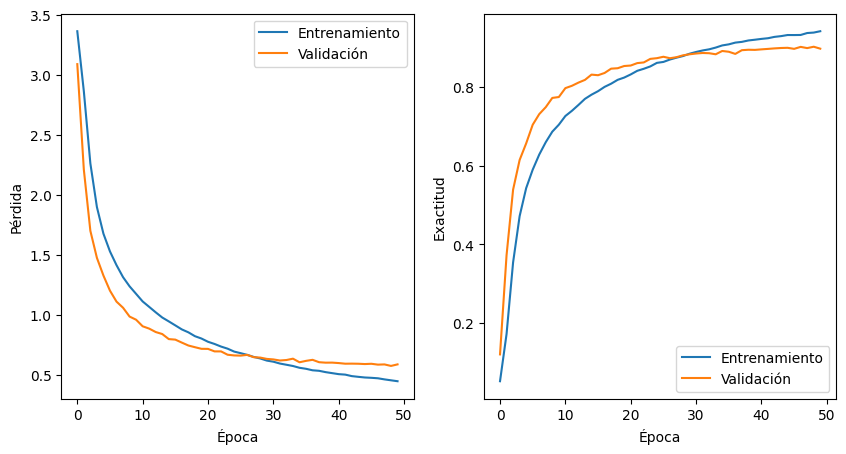

In [48]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

### EVALUAMOS EL MODELO CON MEJORES MÉTRICAS (CNN CONV2D)

In [49]:
def evalua_modelo(modelo, test_dl, dispositivo):
    modelo.eval()  # Colocar el modelo en modo evaluación
    aciertos_por_lote = []
    total_ejemplos = 0
    
    with torch.no_grad():  # Sin calcular los gradientes
        for X, y in test_dl:
            X = X.to(dispositivo)
            y = y.to(dispositivo)
            
            # Realizar las predicciones
            y_hat = modelo(X)
            
            # Calcular la exactitud para el lote
            aciertos = exactitud(y_hat, y)
            
            # Sumar la exactitud por lote (aciertos relativos)
            aciertos_por_lote.append(aciertos.item())
            total_ejemplos += X.size(0)
    
    # Convertir la lista de aciertos a numpy array
    aciertos_por_lote = np.array(aciertos_por_lote)
    
    # Calcular la exactitud total y su desviación estándar
    accuracy_media = np.mean(aciertos_por_lote)
    desviacion_std = np.std(aciertos_por_lote)
    
    return accuracy_media, desviacion_std

In [50]:
test_dl =  DataLoader(
    test_dataset_img,
    batch_size=96,
    shuffle=True
)

In [51]:
# Evaluar el modelo y obtener la exactitud media y desviación estándar
accuracy_media, desviacion_std = evalua_modelo(ConvNeXt, test_dl, device)

print(f"Exactitud (accuracy): {accuracy_media * 100:.2f}%")
print(f"Desviación estándar: {desviacion_std * 100:.2f}%")

Exactitud (accuracy): 89.35%
Desviación estándar: 2.98%


### **ANÁLISIS**

### CONV1D
**Aplanamiento del Espectrograma:** En el caso de Conv1D, el espectrograma se trata esencialmente como una señal aplanada (tiempo * frecuencia). Aunque el espectrograma tiene dos dimensiones, Conv1D interpreta los datos como una secuencia unidimensional, aplicando filtros que se mueven a lo largo de una sola dimensión. Por lo tanto, el modelo puede capturar relaciones temporales dentro de la señal de audio, pero pierde en gran medida la capacidad de capturar correlaciones entre diferentes bandas de frecuencia.

**Procesamiento Secuencial:** Conv1D se adapta bien cuando el objetivo principal es capturar patrones secuenciales o temporales, como cambios en la señal de audio a lo largo del tiempo. Sin embargo, es menos eficaz para captar la estructura conjunta entre tiempo y frecuencia, ya que aplica un filtro unidimensional.

**Resultados observados:** En los primeros 10 períodos de entrenamiento (en el caso de la Conv1D), observamos una rápida reducción de la pérdida y un aumento de la exactitud. Esto indica que el modelo es capaz de extraer patrones temporales, pero puede perder precisión al no capturar relaciones de frecuencia complejas. La exactitud inicial es baja, pero mejora considerablemente en las primeras épocas.

### CONV2D 

**Procesamiento Bidimensional:** La Conv2D aplica filtros que se mueven a lo largo de las dos dimensiones del espectrograma: el tiempo y la frecuencia. Esto permite al modelo aprender tanto patrones temporales como relaciones entre diferentes bandas de frecuencia simultáneamente. Conv2D es más adecuada para tareas donde es importante capturar correlaciones entre frecuencias, como es común en muchas aplicaciones de procesamiento de señales de audio.

**Captura de Relaciones Complejas:** Dado que los espectrogramas son esencialmente imágenes 2D, las convoluciones 2D permiten capturar las características espectrales complejas y las interacciones entre diferentes frecuencias en diferentes momentos. Esto tiende a ser más efectivo en tareas como la clasificación de audio, donde las características de la señal cambian en el tiempo y la frecuencia de manera conjunta.

**Resultados observados:** En el caso de la Conv2D, se observa un descenso más rápido en la pérdida, y la exactitud es mayor desde las primeras épocas en comparación con Conv1D. La Conv2D parece extraer características más representativas del espectrograma desde el inicio, lo que explica las mejores métricas de validación y entrenamiento observadas. Esto se alinea con la capacidad de Conv2D para capturar tanto las relaciones temporales como las frecuenciales en el espectrograma.

### Resultados generales

**Velocidad de Convergencia:** En ambas arquitecturas (Conv1D y Conv2D), la pérdida disminuye de manera constante, y la exactitud mejora con el tiempo. Sin embargo, Conv2D tiende a converger más rápido y con mejores resultados en las primeras épocas. Esto puede deberse a que Conv2D es capaz de capturar relaciones más ricas entre el tiempo y la frecuencia, mientras que Conv1D depende de la estructura temporal principalmente.

**Exactitud Final:** La exactitud obtenida con Conv2D es generalmente superior a la obtenida con Conv1D. Al final del entrenamiento, Conv2D alcanza una exactitud en validación del 90% (aproximadamente), mientras que Conv1D no logra alcanzar niveles tan altos. Esto sugiere que, para espectrogramas, Conv2D es más efectiva para extraer las características complejas que el modelo necesita para clasificar correctamente las señales de audio.